# Kanji Radical Match

Loading data, training, and output.

In [56]:
import utils as u
import torch.nn as nn
import torch
from utils import KanjiFFNN
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
eng_to_rads = dict(list(u.load_eng_to_rads().items()))
eng_tens, rad_tens, eng_vocab, rad_vocab = u.dict_to_tensors(eng_to_rads)

In [3]:
print("Vocabulary size:", len(eng_vocab))
print("Radical vocabulary size:", len(rad_vocab))


Vocabulary size: 5191
Radical vocabulary size: 241


In [4]:
# Print a small sample of our data
print(eng_tens[:5])
print(eng_vocab[:5])
print(rad_tens[:5])
print(rad_vocab[:5])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['%' '(kokuji)' '(north) korea' '(parallels of) latitude' '-']
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
['ノ' 'ハ' 'マ' 'ユ' 'ヨ']


In [5]:
# Example
print(u.get_tensor_from_word("eight", eng_tens, eng_vocab))

tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [6]:
e2r_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1))
criterion = nn.BCELoss()
optimizer = optim.Adam(e2r_model.parameters(), lr=1e-3)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [7]:
epochs = 8

e2r_model.train_fit(eng_tens, rad_tens, optimizer, criterion, epochs=epochs, scheduler=lr_scheduler, verbose=True)

Epoch        1 Loss: 0.08043680340051651
Epoch        2 Loss: 0.08324290066957474
Epoch        3 Loss: 0.0782073587179184
Epoch        4 Loss: 0.07161353528499603
Epoch        5 Loss: 0.06252215802669525
Epoch        6 Loss: 0.04567135125398636
Epoch        7 Loss: 0.03553079441189766
Epoch        8 Loss: 0.034837234765291214


In [8]:
torch.save(e2r_model, "./models/model.pt")

In [9]:
torch.save(e2r_model.state_dict(), "./models/model_state_dict.pt")

In [4]:
loaded_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1))
loaded_model.load_state_dict(torch.load("./models/model_state_dict.pt"))
loaded_model.eval()

KanjiFFNN(
  (input): Linear(in_features=5191, out_features=600, bias=True)
  (hid1): Linear(in_features=600, out_features=400, bias=True)
  (hid2): Linear(in_features=400, out_features=300, bias=True)
  (output): Linear(in_features=300, out_features=241, bias=True)
)

In [6]:
tensor = u.get_tensor_from_word("eight", eng_tens, eng_vocab)
res = loaded_model(tensor)
print(res)

tensor([4.5169e-02, 7.7497e-01, 1.1157e-06, 3.8234e-06, 1.1212e-02, 1.5454e-01,
        3.0724e-10, 1.0417e-02, 8.7129e-03, 5.0595e-07, 1.4035e-09, 3.0790e-05,
        9.0093e-07, 1.6326e-04, 4.4131e-09, 1.2255e-13, 2.5354e-04, 2.2802e-02,
        4.0797e-11, 5.2169e-06, 1.4140e-02, 7.0404e-10, 3.4582e-02, 6.0578e-05,
        8.0677e-07, 6.0121e-10, 5.2097e-09, 6.0176e-03, 2.6384e-06, 8.0892e-05,
        6.8535e-05, 1.4349e-05, 4.3568e-05, 9.2594e-03, 1.6088e-03, 6.4187e-05,
        6.2857e-05, 1.1543e-04, 1.0597e-06, 9.5254e-05, 4.8485e-03, 2.5561e-06,
        3.9986e-02, 2.3706e-03, 3.7992e-06, 5.3930e-06, 1.0353e-04, 1.7145e-04,
        6.9307e-07, 4.5395e-02, 6.8311e-07, 3.0087e-06, 1.9040e-03, 2.1996e-05,
        5.9363e-04, 6.6070e-08, 6.1456e-03, 1.1098e-15, 9.6671e-05, 1.7439e-06,
        1.7499e-03, 1.4793e-04, 5.0801e-03, 1.6181e-05, 3.4169e-09, 8.6248e-10,
        4.9456e-03, 2.5057e-08, 1.4514e-05, 3.3339e-03, 5.9189e-06, 1.2153e-12,
        5.7554e-08, 5.2782e-04, 5.5741e-

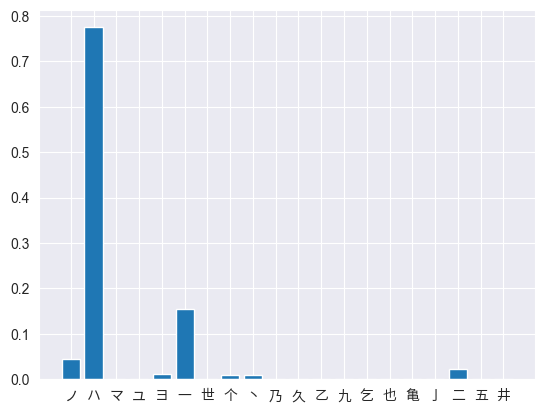

In [7]:
fprop = fm.FontProperties(fname='NotoSansCJKtc-Regular.otf')
radicals = rad_vocab[:20]
probabilities = res.tolist()[:20]

fig, axs = plt.subplots()
axs.bar(radicals, probabilities)
axs.set_xticks(range(len(radicals)), radicals, fontproperties=fprop)
plt.show()

In [55]:
with torch.no_grad():
    preds = loaded_model(eng_tens)
    preds = (preds > 0.5)
    print('Precision:', precision_score(rad_tens, preds, average='micro'))
    print('Recall:', recall_score(rad_tens, preds, average='micro'))
    print('F1 Score:', f1_score(rad_tens, preds, average='micro'))
    print('Accuracy:', accuracy_score(rad_tens, preds))

Precision: 0.6656891495601173
Recall: 0.10261492454273594
F1 Score: 0.17781928836130276
Accuracy: 0.001541128876902331
